# Task 3 - Momentum Overlay

Load data needed for computations. 

In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Utils
from scipy.optimize import minimize 
import Backtest as bt   
import matplotlib.dates as mdates

In [2]:
# SET GLOBAL VALUES
mu_target = 75 / 10000 # Target
w_current = np.array([0,0.4, 0.6]) # current strategy
bond = pd.read_csv("Data_clean/bond_returns.csv")
stock = pd.read_csv("Data_clean/6_Portfolios_ME_Prior_12_2_returns.csv")
bond, stock =bond[["Date", "10YrReturns"]], stock[["Date", "Market Return"]]
stock["Market Return"] = stock["Market Return"] /100  
data = pd.merge(bond,stock, how='left', on = "Date")
RF = pd.read_csv("Data_clean/FF_cleaned.csv")
data = pd.merge(data.copy(),RF[["Date","RF"]], 'left',on = "Date" )
data["RF"] = data["RF"] /100 # assumed this must hold

MOMdep = pd.read_csv("Data_clean/25_Portfolios_ME_Prior_12_2_returns.csv")
MOMdep = MOMdep[["Date", "BIG LoPRIOR", "BIG HiPRIOR"]]
data = pd.merge(data.copy(),MOMdep, 'left',on = "Date" )
data["BIG LoPRIOR"], data["BIG HiPRIOR"] =data["BIG LoPRIOR"] /100, data["BIG HiPRIOR"] /100

In [3]:
data

,Date,10YrReturns,Market Return,RF,BIG LoPRIOR,BIG HiPRIOR
0,1990-01-31,-0.025702,-0.0724,0.0057,0.0009,-0.0942
1,1990-02-28,0.001547,0.0167,0.0057,0.0439,0.0113
2,1990-03-31,-0.002251,0.0246,0.0064,-0.0129,0.0334
3,1990-04-30,-0.017928,-0.0266,0.0069,-0.0619,-0.0179
4,1990-05-31,0.035839,0.0909,0.0068,0.1079,0.0999
...,...,...,...,...,...,...
403,2023-08-31,-0.006376,-0.0190,0.0045,-0.0899,0.0136
404,2023-09-30,-0.035790,-0.0480,0.0043,-0.0491,-0.0676
405,2023-10-31,-0.018635,-0.0261,0.0047,-0.0494,-0.0282
406,2023-11-30,0.044330,0.0930,0.0044,0.0784,0.1205


3.a 

In [4]:
# initial overlay
olay = 0.25
# The new Equity time-series:
data_ol = data.copy()

data_ol["Market Return"] =  data_ol["Market Return"] - olay * data_ol["BIG LoPRIOR"] + olay * data_ol["BIG HiPRIOR"]

In [5]:
mu = np.mean([data_ol["RF"],data_ol["10YrReturns"],data_ol["Market Return"]],axis=1)
sigma = np.cov([data_ol["RF"],data_ol["10YrReturns"],data_ol["Market Return"]])
mu0 = np.mean(data_ol["RF"])
mu_e = np.mean([data_ol["10YrReturns"]-data_ol["RF"],data_ol["Market Return"]-data_ol["RF"]],axis=1)
sigma_e = np.cov([data_ol["10YrReturns"]-data_ol["RF"],data_ol["Market Return"]-data_ol["RF"]])
print("Mu", mu,"Sigma", sigma)

Mu [0.00213848 0.00432316 0.01020772] Sigma [[ 3.53053036e-06  4.63693106e-06 -3.58629318e-08]
 [ 4.63693106e-06  4.51987323e-04 -1.16761672e-05]
 [-3.58629318e-08 -1.16761672e-05  1.77650363e-03]]


In [6]:
# Test weights:
test = Utils.get_weights(mu,sigma, mu_target)
print(test)

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


[array([0. , 0.4, 0.6]), array([0.        , 0.46014004, 0.53985996]), array([-0.07341663,  0.56081306,  0.51260357]), array([0.        , 0.70697303, 0.29302697]), array([-0.28954246,  0.85717709,  0.43236538])]


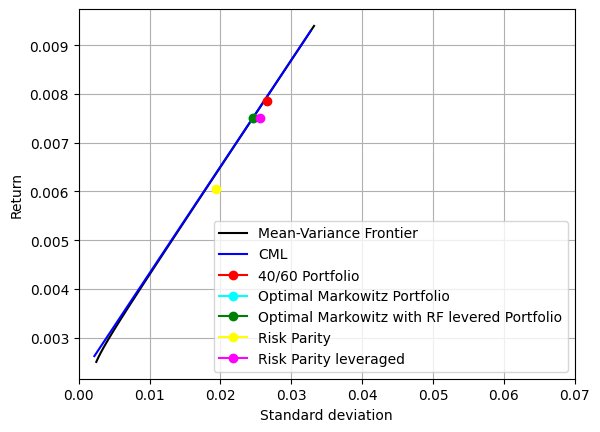

In [7]:
# Preliminaries
mu_vec = np.array([mu_target + i*0.0001 for i in range(-80,40)])
sigma_vec = [Utils.mv_analysis(mu, sigma,i)[1] for i in mu_vec]
sigma_vec_cml = [0]+ sigma_vec
cml = [ mu0 + np.sqrt(mu_e @ np.linalg.inv(sigma_e) @ mu_e) * i for i in sigma_vec_cml]
sigma_test, mu_test = [np.sqrt(w @ sigma @ w) for w in test],  [w @ mu for w in test]

# plot
plt.plot(sigma_vec[30:100], mu_vec[30:100], color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_vec_cml[30:100], cml[30:100], color = "blue",label = "CML")
plt.plot(sigma_test[0],mu_test[0],marker='o', color = "red", label = "40/60 Portfolio")
plt.plot(sigma_test[1],mu_test[1],marker='o', color = "cyan", label = "Optimal Markowitz Portfolio")
plt.plot(sigma_test[2],mu_test[2],marker='o', color = "green", label = "Optimal Markowitz with RF levered Portfolio")
plt.plot(sigma_test[3],mu_test[3],marker='o', color = "yellow", label = "Risk Parity")
plt.plot(sigma_test[4],mu_test[4],marker='o', color = "magenta", label = "Risk Parity leveraged")
plt.xlim(left = 0.0,right= 0.07)

plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

In [8]:
initial_fits = 3

test1, weights1 = bt.backtest_k(ind=data_ol, mu_target=mu_target,m=initial_fits,l=1,K=1) 


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:217: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.up

C:\Users\andre\AppData\Local\Temp\ipykernel_24228\4048542202.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


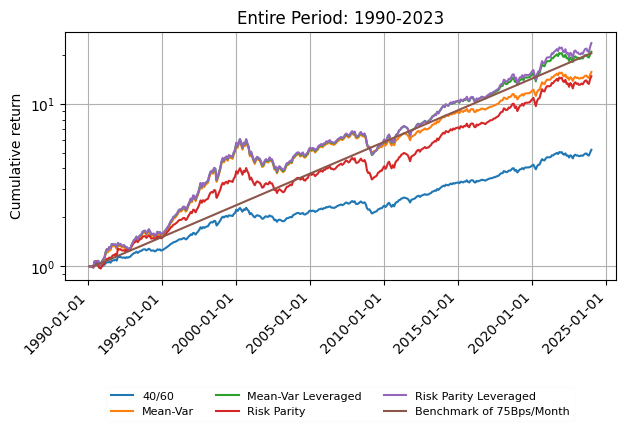

In [9]:
time = pd.date_range(test1["Date"][0],test1["Date"][len(test1["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test1["R_40/60"], label="40/60")
ax.plot(time,test1["R_MV"], label="Mean-Var")
ax.plot(time,test1["R_MVL"], label="Mean-Var Leveraged")
ax.plot(time,test1["R_RP"], label="Risk Parity")
ax.plot(time,test1["R_RPL"], label="Risk Parity Leveraged")
ax.plot(time[initial_fits:], [(mu_target+1)**t for t in range(0,len(time)-initial_fits)],
         label = "Benchmark of 75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.title("Entire Period: 1990-2023")
plt.show()

It seems like the backtest is less volatile using the momentum overlay. Might be preferable but overall return would be lower. 

3.b Adding the cost. 

In [10]:
# The new Equity time-series:
data_ol_cost = data_ol.copy()

data_ol_cost["Market Return"] =  data_ol["Market Return"] - Utils.manager_fee(data_ol["Market Return"] )
# Subtract cost in the backtest implementation. 
initial_fits = 3

test2, weights2 = bt.backtest_k(ind=data_ol_cost, mu_target=mu_target,m=initial_fits,l=1,K=1) 

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:217: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.up

C:\Users\andre\AppData\Local\Temp\ipykernel_24228\3323095644.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


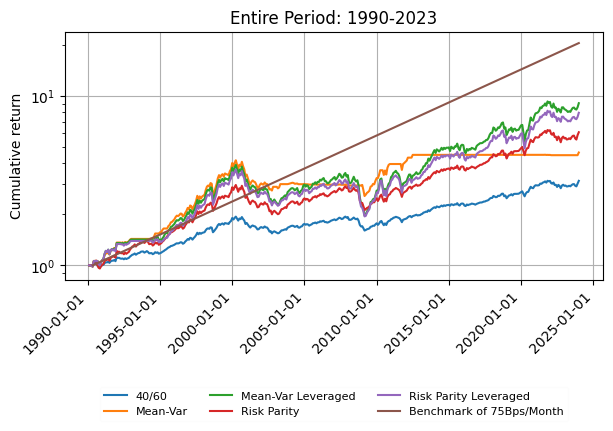

In [11]:
time = pd.date_range(test2["Date"][0],test2["Date"][len(test2["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test2["R_40/60"], label="40/60")
ax.plot(time,test2["R_MV"], label="Mean-Var")
ax.plot(time,test2["R_MVL"], label="Mean-Var Leveraged")
ax.plot(time,test2["R_RP"], label="Risk Parity")
ax.plot(time,test2["R_RPL"], label="Risk Parity Leveraged")
ax.plot(time[initial_fits:], [(mu_target+1)**t for t in range(0,len(time)-initial_fits)],
         label = "Benchmark of 75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.title("Entire Period: 1990-2023")
plt.show()

3.c b decreases performance. 

3.d

In [12]:
# initial overlay
olay = 0.50
# The new Equity time-series:
data_ol = data.copy()
data_ol["Market Return"] =  data_ol["Market Return"] - olay * data_ol["BIG LoPRIOR"] + olay * data_ol["BIG HiPRIOR"]

data_ol_cost["Market Return"] =  data_ol["Market Return"] - Utils.manager_fee(data_ol["Market Return"] )

data_ol["Market Return"] =  data_ol["Market Return"] - olay * data_ol["BIG LoPRIOR"] + olay * data_ol["BIG HiPRIOR"]
mu = np.mean([data_ol["RF"],data_ol["10YrReturns"],data_ol["Market Return"]],axis=1)
sigma = np.cov([data_ol["RF"],data_ol["10YrReturns"],data_ol["Market Return"]])
mu0 = np.mean(data_ol["RF"])
mu_e = np.mean([data_ol["10YrReturns"]-data_ol["RF"],data_ol["Market Return"]-data_ol["RF"]],axis=1)
sigma_e = np.cov([data_ol["10YrReturns"]-data_ol["RF"],data_ol["Market Return"]-data_ol["RF"]])

In [13]:
initial_fits = 3

test3, weights3 = bt.backtest_k(ind=data_ol_cost, mu_target=mu_target,m=initial_fits,l=1,K=1) 

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:217: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.up

C:\Users\andre\AppData\Local\Temp\ipykernel_24228\2436538126.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


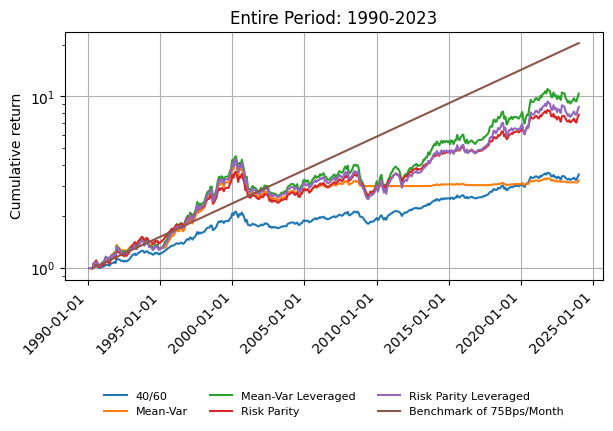

In [14]:
time = pd.date_range(test3["Date"][0],test3["Date"][len(test3["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test3["R_40/60"], label="40/60")
ax.plot(time,test3["R_MV"], label="Mean-Var")
ax.plot(time,test3["R_MVL"], label="Mean-Var Leveraged")
ax.plot(time,test3["R_RP"], label="Risk Parity")
ax.plot(time,test3["R_RPL"], label="Risk Parity Leveraged")
ax.plot(time[initial_fits:], [(mu_target+1)**t for t in range(0,len(time)-initial_fits)],
         label = "Benchmark of 75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.title("Entire Period: 1990-2023")
plt.show()

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
C:\Users\andre\AppData\Local\Temp\ipykernel_24228\3834158626.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


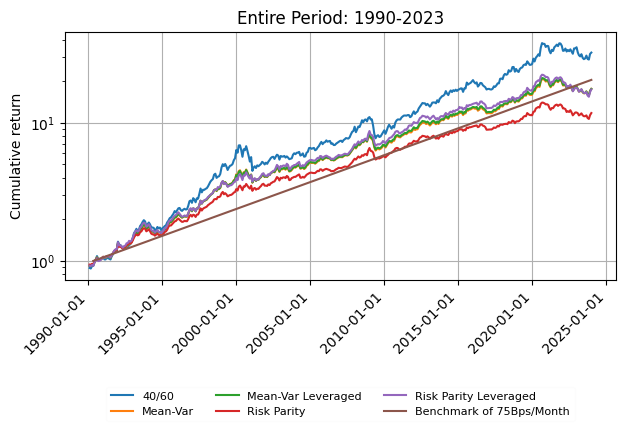

In [15]:
initial_fits = 3

test3, w0t,w1t,w2t  = bt.backtest_naive(ind=data_ol, mu_target=mu_target) 
time = pd.date_range(test3["Date"][0],test3["Date"][len(test3["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test3["R_40/60"], label="40/60")
ax.plot(time,test3["R_MV"], label="Mean-Var")
ax.plot(time,test3["R_MVL"], label="Mean-Var Leveraged")
ax.plot(time,test3["R_RP"], label="Risk Parity")
ax.plot(time,test3["R_RPL"], label="Risk Parity Leveraged")
ax.plot(time[initial_fits:], [(mu_target+1)**t for t in range(0,len(time)-initial_fits)],
         label = "Benchmark of 75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.title("Entire Period: 1990-2023")
plt.show()